In [1]:
import numpy as np
import qiskit

In [2]:
from qiskit.providers.aer import QasmSimulator

In [3]:
def c_amod15(a, power):
    """Controlled multiplication by a mod 15"""
    if a not in [2,4,7,8,11,13]:
        raise ValueError("'a' must be 2,4,7,8,11 or 13")
    U = qiskit.QuantumCircuit(4)        
    for iteration in range(power):
        if a in [2,13]:
            U.swap(0,1)
            U.swap(1,2)
            U.swap(2,3)
        if a in [7,8]:
            U.swap(2,3)
            U.swap(1,2)
            U.swap(0,1)
        if a in [4, 11]:
            U.swap(1,3)
            U.swap(0,2)
        if a in [7,11,13]:
            for q in range(4):
                U.x(q)
    U = U.to_gate()
    U.name = "%i^%i mod 15" % (a, power)
    c_U = U.control()
    return c_U

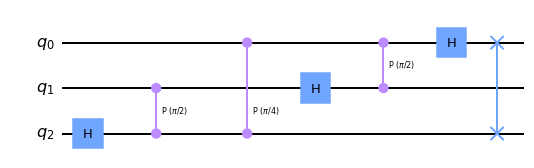

In [4]:
qft = qiskit.QuantumCircuit(3, name = "qft")
qft.h(2)
qft.cp(np.pi/2,1,2)
qft.cp(np.pi/4,0,2)
qft.h(1)
qft.cp(np.pi/2,0,1)
qft.h(0)
qft.swap(0,2)
qft.draw('mpl')

In [5]:
qft_instr = qft.to_instruction()

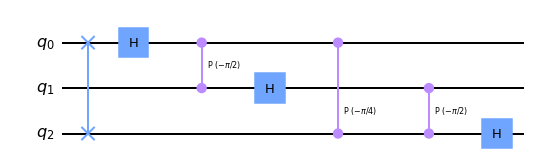

In [6]:
qft_inverse = qiskit.QuantumCircuit(3, name="qft^-1")
qft_inverse.swap(0,2)
qft_inverse.h(0)
qft_inverse.cp(-np.pi/2, 0, 1)
qft_inverse.h(1)
qft_inverse.cp(-np.pi/4, 0, 2)
qft_inverse.cp(-np.pi/2, 1, 2)
qft_inverse.h(2)
qft_inverse.draw('mpl')


In [7]:
qft_inverse_instr = qft_inverse.to_instruction()

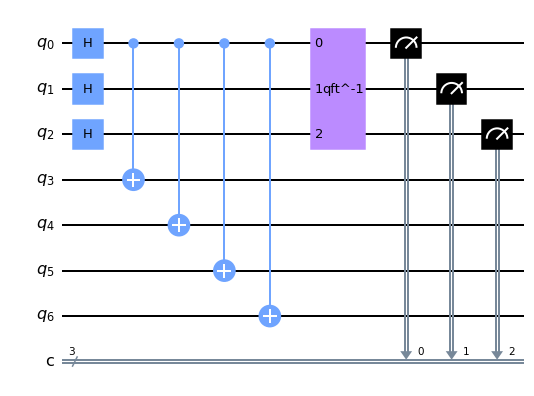

In [8]:
shors_full = qiskit.QuantumCircuit(7, 3, name = 'shors')
# shors_full.rx(0.2*np.pi, range(5)) # Noise
shors_full.h(0)
shors_full.h(1)
shors_full.h(2)
shors_full.cx(0,[3,4,5,6])
'''
for q in range(1):
    shors_full.append(c_amod15(11, 2**q), [q] + [i+3 for i in range(4)])
'''
shors_full.append(qft_inverse_instr, [0,1,2])
shors_full.measure(range(3),range(3))
shors_full.draw('mpl')

{'100': 494, '000': 530}


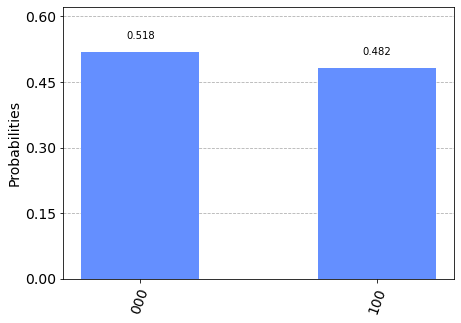

In [9]:
backend = QasmSimulator()
circ_compiled = qiskit.transpile(shors_full, backend)
job_sim = backend.run(circ_compiled, shots = 1024)
results_sim = job_sim.result()
counts = results_sim.get_counts(circ_compiled)
print(counts)
qiskit.visualization.plot_histogram(counts)